In [1]:
import jieba
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import random

In [8]:
# 读取停用词表
stop_lst = []
with open("stopwords.txt") as f:
    for line in f:
        stop_lst.append(line.strip())
f.close()

In [9]:
# 数据清洗，去掉停用词
def cut2(x):
    segs = []
    for word in jieba.cut(x):
        if word not in stop_lst:
            segs.append(word)
    return segs

In [10]:
# 切分
def cut(x):
    return ' '.join(jieba.cut(x))

In [11]:
cut('无额外依赖，安装和使用都非常方便')

'无 额外 依赖 ， 安装 和 使用 都 非常 方便'

In [ ]:
news = pd.read_csv('../sqlResult_1558435.csv', encoding = 'gb18030')        # 读取语料
news = pd.DataFrame(news['content'].astype(str)) # 转类型，防止训练时报错
news['seg'] = news['content'].apply(cut) # 切分
news['seg']
# news['seg'].to_csv('articles_after_segs.txt', sep='\t', index=False)    # 保存切分后的文本
# print(news['seg'].shape)

In [2]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, word2vec, KeyedVectors

In [4]:
path = get_tmpfile("all_vec.model")        # 创建临时文件
sentences = word2vec.LineSentence('wiki_and_news_all.txt')        # 读取预料

# Word2Vec的参数说明:https://blog.csdn.net/szlcw1/article/details/52751314
# size:特征向量的维度; window:当前词与预测词在一个句子中的最大距离；
# min_count: 词频少于min_count次数的单词会被丢弃掉
# workers:控制训练的并行数
model = Word2Vec(sentences, size=100, window=5, min_count=3, workers=4)        # 训练模型
model.save("all_vec.model")         # 保存模型
model.wv.save_word2vec_format('all_vec_format.txt')        # 将词向量以文本形式输出

In [51]:
# 测试线性相关性
def analogy(x1, x2, y1):
#     results = model.wv.most_similar(positive = [y1, x2], negative = [x1])
    results = model.wv.most_similar(positive = [x1, y1], negative = [x2])
    return results[0]

In [48]:
# model = Word2Vec.load("word2vec.model")      # 加载已生成的模型
model = Word2Vec.load("news_vec.model")        # 加载已生成的模型

# word2vec = KeyedVectors.load_word2vec_format('word2vec_format.txt',binary=False)  # 加载已生成的模型

In [58]:
# 测试训练结果
# print(model.wv['西安'])

# 词向量的语义相似性
print(model.wv.most_similar("西安"))

# 词向量的语义线性关系
print(analogy("美国", "中国", "汉语"))
print(analogy("美国", "美国", "奥巴马"))


# 计算两个单词之间的余弦相似度
print(model.wv.similarity('北京','北京'))
print(model.wv.similarity("西安","陕西"), model.wv.similarity("陕西","西安"))

[('-', 0.6891407370567322), ('ｎ', 0.6187101602554321), ('投放', 0.6107930541038513), ('尼', 0.6086283922195435), ('赠送', 0.6075456142425537), ('这次', 0.6065137386322021), ('巩固', 0.5988368391990662), ('市委', 0.5970014333724976), ('小镇', 0.5929998159408569), ('官兵', 0.5919922590255737)]
('氧气', 0.539583683013916)
('脱贫致富', 0.6674659252166748)
1.0
0.4783481 0.4783481


### 用t-sne进行词向量的可视化

In [96]:
# 参考：https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

def tsne_plot(model):
    labels = []
    tokens = []
    
    # list()使得可以通过索引取出一部分词向量
    for word in list(model.wv.vocab)[0:300]:
        tokens.append(model[word])
        labels.append(word)
        
    # 参考：https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    # perplexity: 最近邻居的熟练 
    # n_components 嵌入空间的维度
    # init: 嵌入的初始化方法，random/pca
    # n_iter：优化的最大迭代次数
    # random_state:随机数生成器的种子
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5,2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/huazai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/huazai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/huazai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


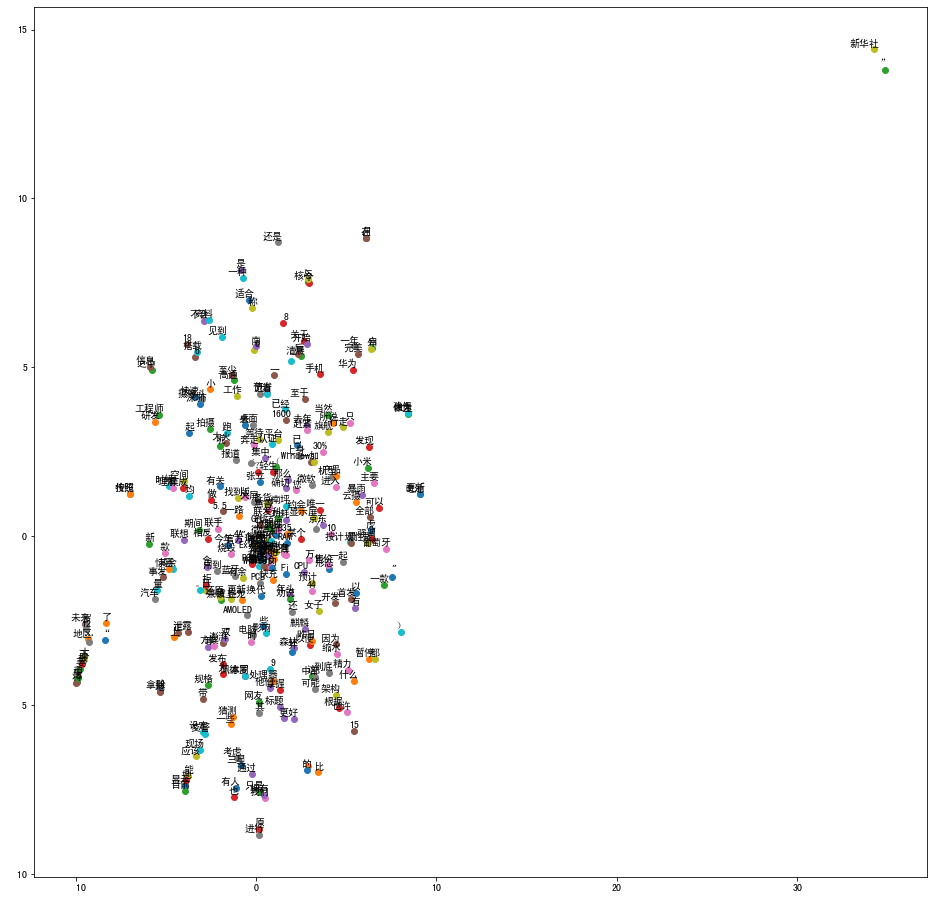

In [97]:
tsne_plot(model)